# Read Model VAE from astroml

https://www.astroml.org/book_figures/chapter9/fig_sdss_vae.html


- update 2023-04-23


In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Import some generally useful packages



import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata


#from astroML.datasets import sdss_corrected_spectra

# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

/Users/dagoret/anaconda3/envs/fidle23/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
from sklearn.model_selection import train_test_split
import h5py

In [4]:
WL_BALMER_BREAK= 3646.0 

In [5]:
hf = h5py.File('SLspectra.hdf5', 'r') 
data_in = hf['flambda'][:]
wl_in = hf['wl'][:]
target = hf['quantile'][:]

# other data
redshift = hf['redshift'][:]
Rmag = hf['Rmag'][:]
RT = hf['RT'][:]
RV = hf['RV'][:]
ra = hf['ra'][:]
dec = hf['dec'][:]
fracinfbalmer = hf['fracinfbalmer'][:]
print(hf.keys())

<KeysViewHDF5 ['Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'flambda', 'fracinfbalmer', 'num', 'quantile', 'ra', 'redshift', 'wl']>


In [6]:
WL = wl_in
NWL = data_in.shape[1]
NSAMPL = data_in.shape[0]

In [7]:
idx_blue = np.where (WL<WL_BALMER_BREAK)[0]
idx_red = np.where (WL>=WL_BALMER_BREAK)[0]
wl_blue = WL[idx_blue]
wl_red = WL[idx_red]

In [8]:
#x_train, x_test, y_train, y_test = train_test_split(data_in,
#                                          target,
#                                          test_size=0.2)

In [9]:
# Fetch and prepare the data
#data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
#spectra = sdss_corrected_spectra.reconstruct_spectra(data)
#wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

spectra = data_in
wavelengths = wl_in

# normalize spectra by integrated flux and subtract out mean, for easier training
spectranorms = np.mean(spectra, axis=1)
normedspectra = spectra / spectranorms[:, None]

#already normalized spectra in prepareData, but it does not work ????
#normedspectra = spectra

meanspectrum = np.mean(normedspectra, axis=0)
normedspectra -= meanspectrum[None, :]

# split data into 3:1 train:test
torch.manual_seed(802)  # seed used for book figure
dataset = torchdata.TensorDataset(torch.tensor(normedspectra))
trainnum = normedspectra.shape[0] // 4 * 3
traindata, testdata = torchdata.random_split(dataset, [trainnum, normedspectra.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, batch_size=64, shuffle=True)

# Definition of VAE model 

In [10]:
# define structure of variation autoencoder
class VAE(nn.Module):
    def __init__(self, nhidden=250):
        super(VAE, self).__init__()

        self.encode_fc = nn.Linear(NWL, nhidden)
        self.mu        = nn.Linear(nhidden, 2)
        self.logvar    = nn.Linear(nhidden, 2)

        self.decode_fc = nn.Linear(2, nhidden)
        self.output    = nn.Linear(nhidden, NWL)

    def encode(self, x):
        h = F.relu(self.encode_fc(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h = F.relu(self.decode_fc(z))
        return self.output(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



## Read model

In [11]:
#torch.save(model,"modelvae_fromastroml_pytorch_v1.pth")
#torch.save(model.state_dict(),"modelvae_fromastroml_pytorch_v2.pth")

In [12]:
model = VAE()

In [13]:
model.load_state_dict(torch.load("modelvae_fromastroml_pytorch_v2.pth"))

<All keys matched successfully>

## plot results

### Generate a single spectrum from latent variables

In [14]:
z0 = np.array([0.,0], dtype=np.float32)

In [15]:
label = f"$(z_1,z_2) = $ ({z0[0]}, {z0[1]})"

In [16]:
spectrum = model.decode(torch.tensor(z0))

In [17]:
# if we are not detaching, need no_grad()
#with torch.no_grad():
#    plt.plot(wavelengths, meanspectrum+spectrum.numpy(),'r-')

In [18]:
# here we need to detach to convert the tensor to another tensor that isn't requiring a gradient 
dspectrum = spectrum.detach().numpy()

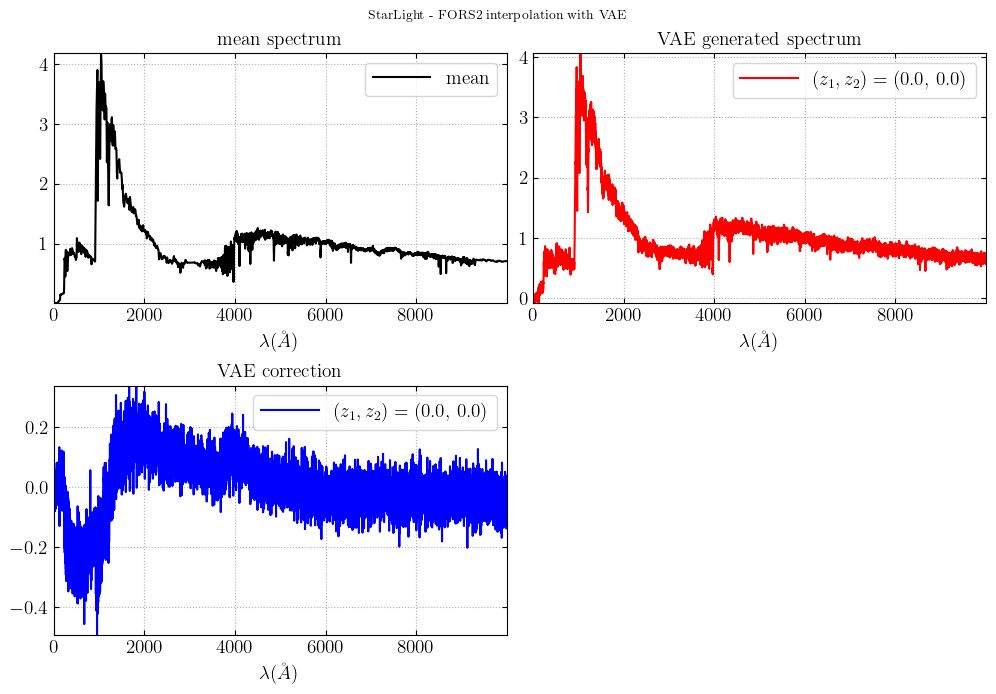

In [19]:
fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(2,2,1)
ax.plot(wavelengths, meanspectrum,'k-',label="mean")
ax.set_xlabel("$\lambda (\AA)$")
ax.grid()
ax.legend()
ax.set_title("mean spectrum")
ax=fig.add_subplot(2,2,2)
ax.plot(wavelengths, meanspectrum+dspectrum,'r-',label=label)
ax.set_xlabel("$\lambda (\AA)$")
ax.grid()
ax.legend()
ax.set_title("VAE generated spectrum")
ax=fig.add_subplot(2,2,3)
ax.plot(wavelengths, dspectrum,'b-',label=label)
ax.set_xlabel("$\lambda (\AA)$")
ax.grid()
ax.legend()
ax.set_title("VAE correction")

plt.suptitle("StarLight - FORS2 interpolation with VAE")
plt.tight_layout()
plt.show()

### Scan a grid of latent variables

In [20]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors2 = scalarMap2.to_rgba(all_redshifts, alpha=1)

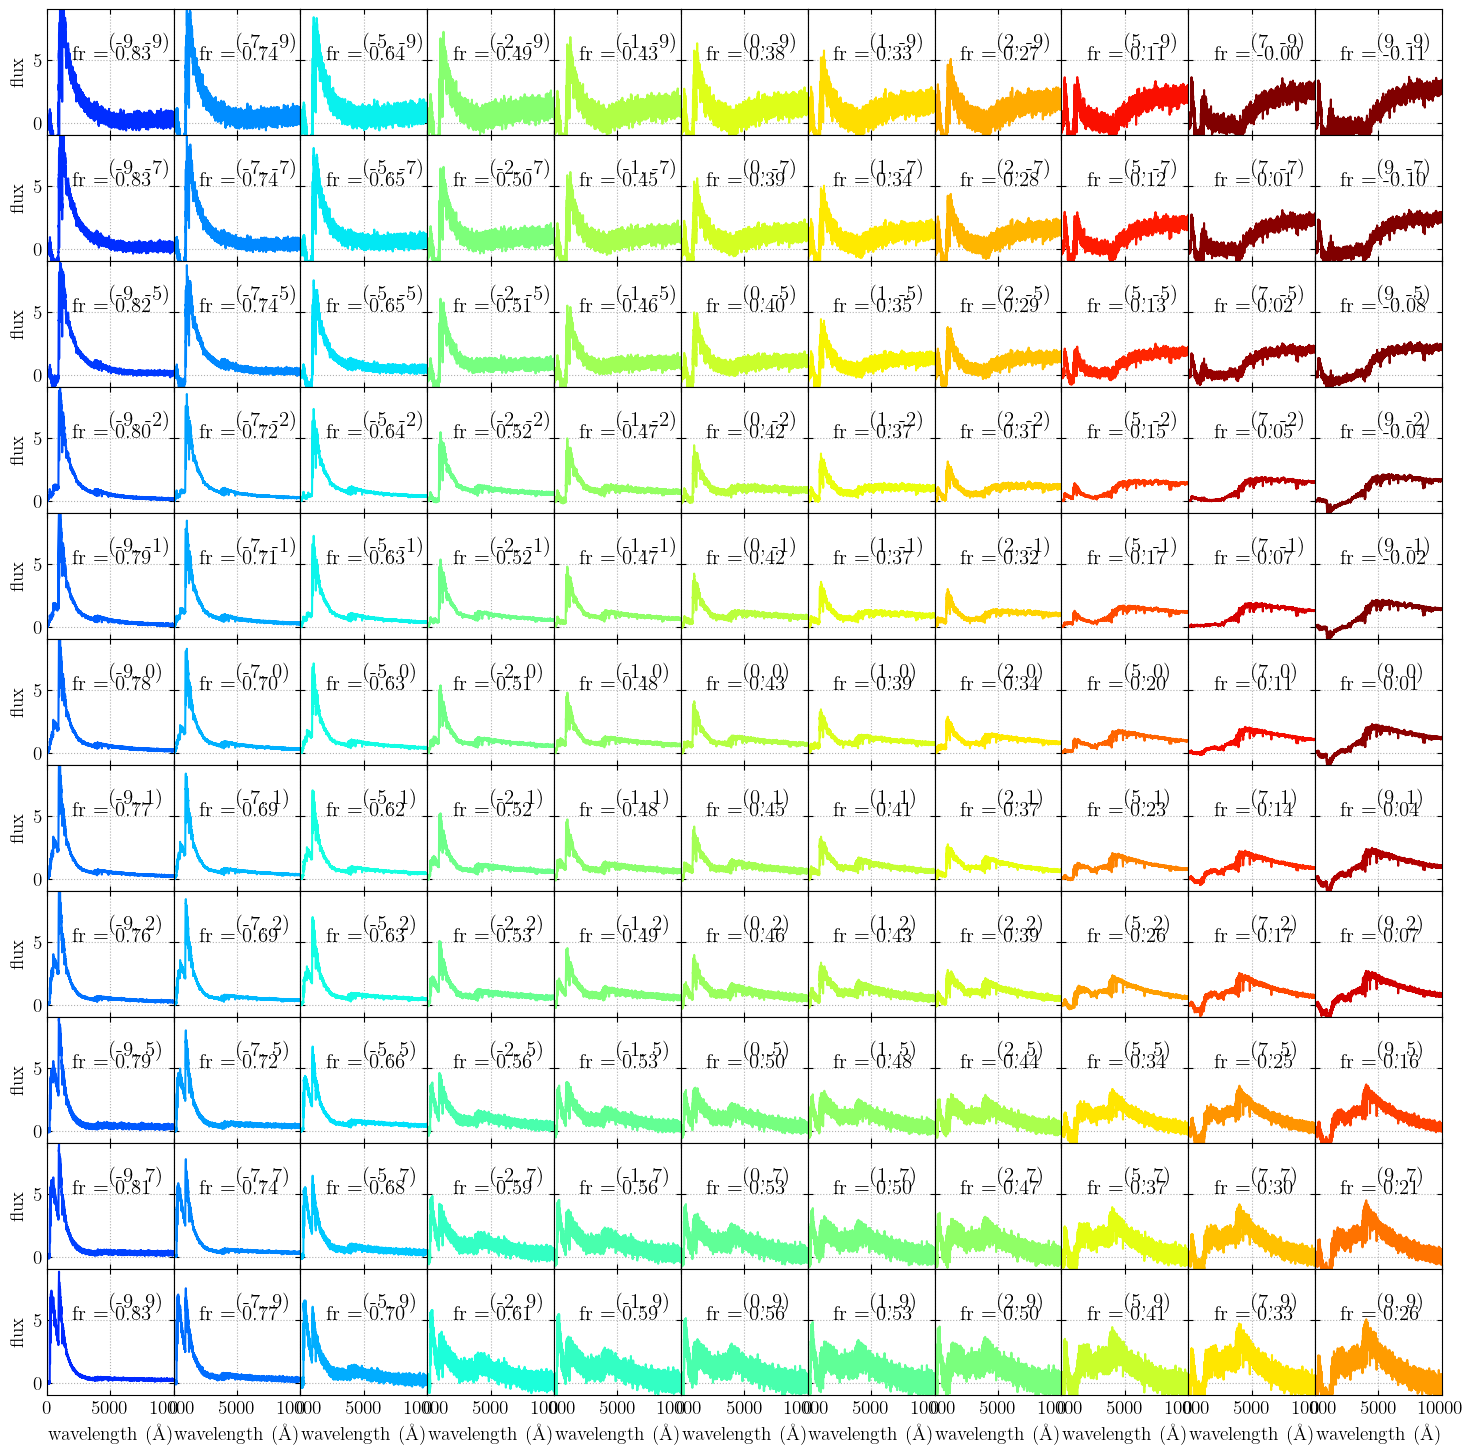

In [21]:
# plot results

with torch.no_grad():
    # sort latent parameters from most constrained to least constrained
    testspec = dataset[:][0]
    recon, mu, logvar = model(testspec)
    zorder = np.argsort(np.mean(logvar.numpy(), axis=0))

    fig = plt.figure(figsize=(18,18))
    fig.subplots_adjust(hspace=0, wspace=0)
    parvalues = [-9,-7,-5,-2.,-1,0.,1,2.,5,7,9]
    for i, z1 in enumerate(parvalues):
        for j, z2 in enumerate(parvalues):
            # get z1 to vary left to right, z2 bottom to top
            
            #idx_fig = (2-j)*len(parvalues)+i+1
            idx_fig = j*len(parvalues)+i +1
            
        
            ax = fig.add_subplot(11, 11, idx_fig)

            z = np.zeros((1,2), dtype=np.float32)
            #z[0, zorder] = z1, z2 # set z1 is more constrained of the two latent parameters
            z[0, zorder] = z2, z1 # set z1 is more constrained of the two latent parameters
            spectrum = model.decode(torch.tensor(z))
            dspectrum = spectrum.numpy()[0,:]
            fullspectrum = meanspectrum+dspectrum
            
            flux_blue = fullspectrum[idx_blue]
            flux_red  = fullspectrum[idx_red]
            flux_integ=np.zeros(7)
            flux_integ[0] =  np.trapz(flux_blue ,wl_blue)
            flux_integ[1] =  np.trapz(flux_red ,wl_red)
            flux_integ[2] = flux_integ[0] + flux_integ[1] 
            flux_integ[3] = flux_integ[0] / flux_integ[2] 
            flux_integ[4] = flux_integ[1] / flux_integ[2] 
            flux_integ[5] = flux_integ[0] / flux_integ[1] 
            flux_integ[6] = flux_integ[1] / flux_integ[0] 
            
            color_spec = scalarMap.to_rgba(1-flux_integ[3], alpha=1)
    
            
            ax.plot(wavelengths,fullspectrum ,color=color_spec)
            ax.grid()
            ax.text(5000, 6, '(%i, %i)' % (z1,z2),fontsize=15)
            ax.text(2000, 5, f'fr = {flux_integ[3]:.2f}',fontsize=15)

            ax.set_xlim(0, 10000)
            ax.set_ylim(-1, 9)

            if i == 0:
                ax.set_ylabel('flux')
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
            if j == len(parvalues)-1:
                ax.set_xlabel(r'${\rm wavelength\ (\AA)}$')
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
#plt.tight_layout() 
plt.show()

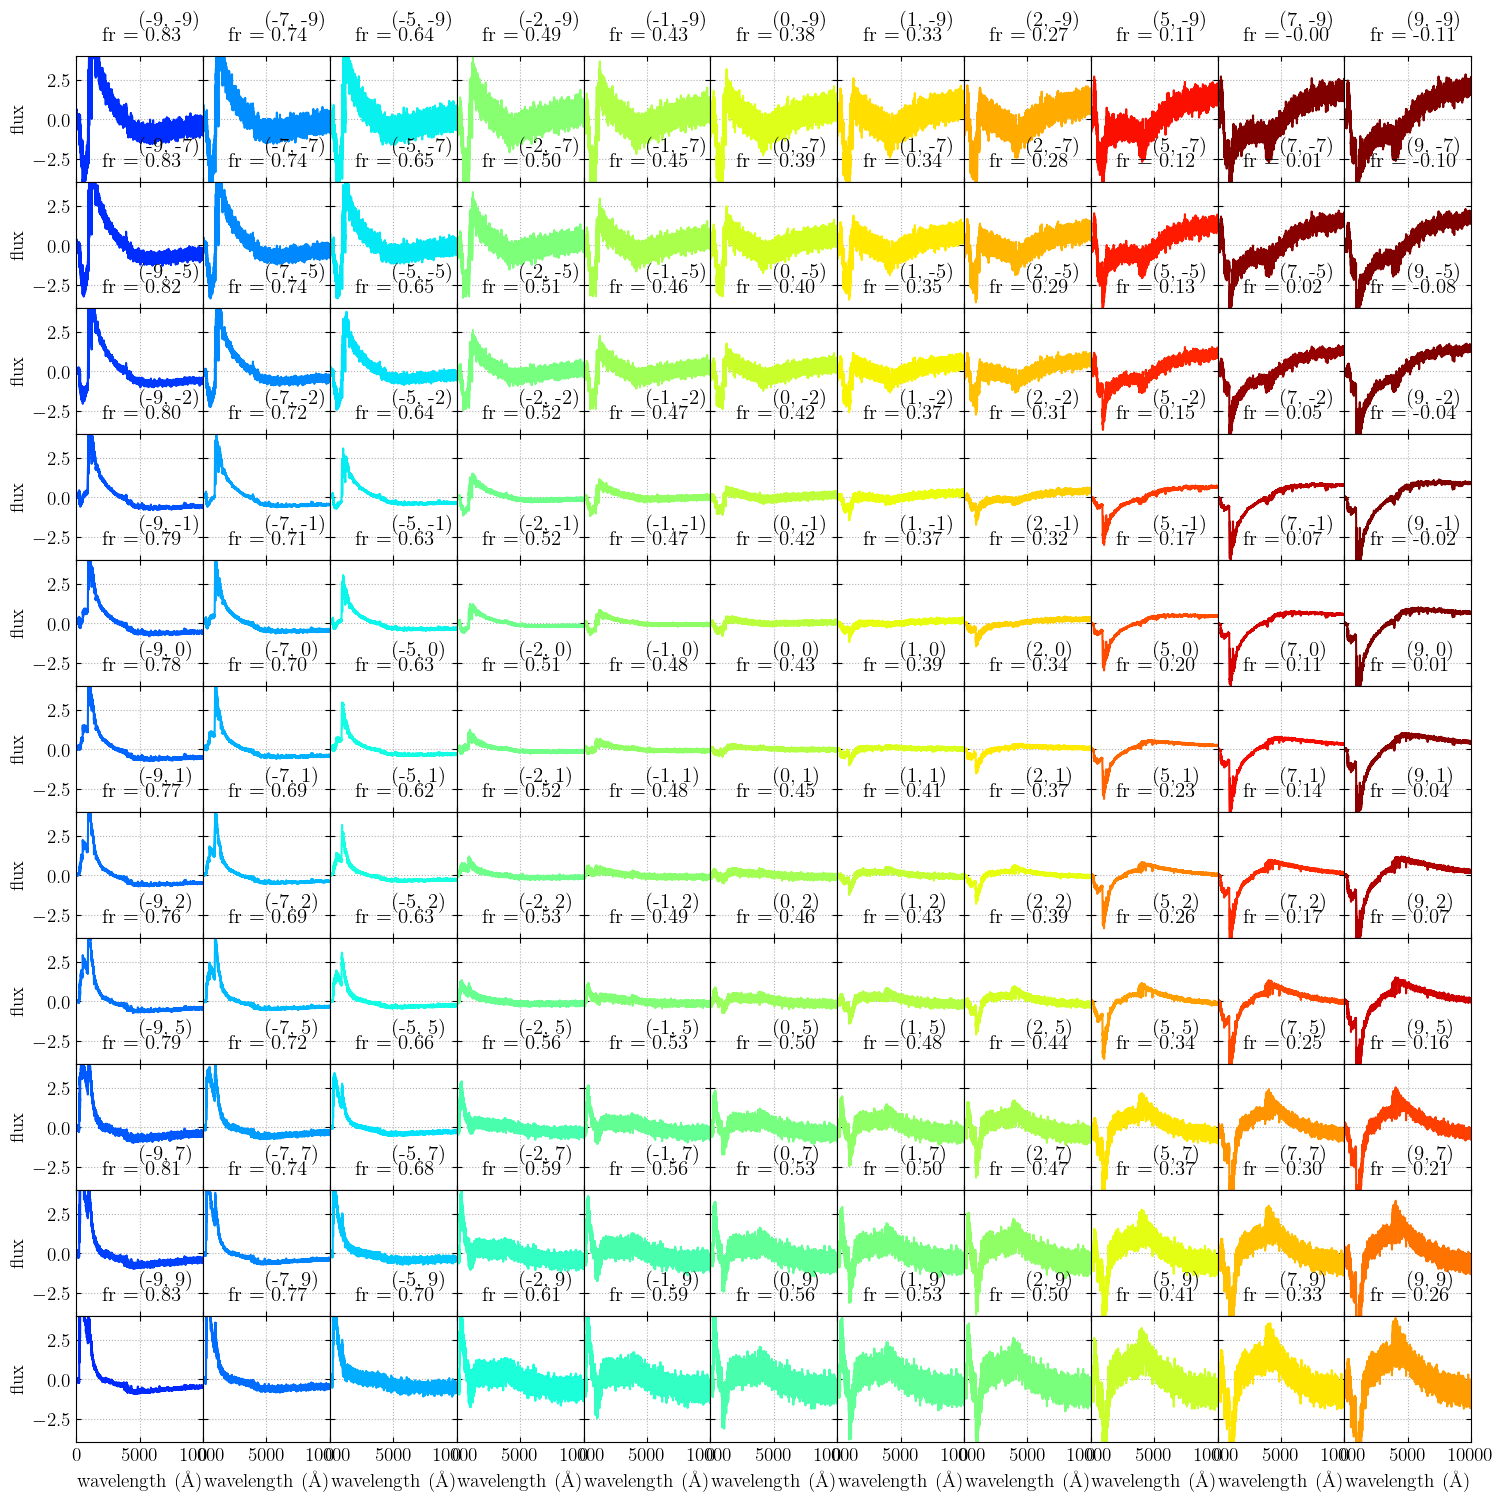

In [22]:
# plot results

with torch.no_grad():
    # sort latent parameters from most constrained to least constrained
    testspec = dataset[:][0]
    recon, mu, logvar = model(testspec)
    zorder = np.argsort(np.mean(logvar.numpy(), axis=0))

    fig = plt.figure(figsize=(18,18))
    fig.subplots_adjust(hspace=0, wspace=0)
    parvalues = [-9,-7,-5,-2.,-1,0.,1,2.,5,7,9]
    for i, z1 in enumerate(parvalues):
        for j, z2 in enumerate(parvalues):
            # get z1 to vary left to right, z2 bottom to top
            
            #idx_fig = (2-j)*len(parvalues)+i+1
            idx_fig = j*len(parvalues)+i +1
            
        
            ax = fig.add_subplot(11, 11, idx_fig)

            z = np.zeros((1,2), dtype=np.float32)
            #z[0, zorder] = z1, z2 # set z1 is more constrained of the two latent parameters
            z[0, zorder] = z2, z1 # set z1 is more constrained of the two latent parameters
            spectrum = model.decode(torch.tensor(z))
            dspectrum = spectrum.numpy()[0,:]
            fullspectrum = meanspectrum+dspectrum
            
            flux_blue = fullspectrum[idx_blue]
            flux_red  = fullspectrum[idx_red]
            flux_integ=np.zeros(7)
            flux_integ[0] =  np.trapz(flux_blue ,wl_blue)
            flux_integ[1] =  np.trapz(flux_red ,wl_red)
            flux_integ[2] = flux_integ[0] + flux_integ[1] 
            flux_integ[3] = flux_integ[0] / flux_integ[2] 
            flux_integ[4] = flux_integ[1] / flux_integ[2] 
            flux_integ[5] = flux_integ[0] / flux_integ[1] 
            flux_integ[6] = flux_integ[1] / flux_integ[0] 
            
            color_spec = scalarMap.to_rgba(1-flux_integ[3], alpha=1)
    
            
            ax.plot(wavelengths,dspectrum ,color=color_spec)
            ax.grid()
            ax.text(5000, 6, '(%i, %i)' % (z1,z2),fontsize=15)
            ax.text(2000, 5, f'fr = {flux_integ[3]:.2f}',fontsize=15)

            ax.set_xlim(0, 10000)
            ax.set_ylim(-4, 4)

            if i == 0:
                ax.set_ylabel('flux')
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
            if j == len(parvalues)-1:
                ax.set_xlabel(r'${\rm wavelength\ (\AA)}$')
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
#plt.tight_layout()                
plt.show()